# DS-7331 Machine Learning Mini Project
## Airbnb Price Data - Logistic and SVM
### Allen Miller, Ana Glaser, Jake Harrison, Lola Awodipe

https://nbviewer.jupyter.org/github/allenmiller17/SMU_7331_ML1_Project_1/blob/main/Project_1_Final_Write_Up.ipynb

In [58]:
#loading libraries
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
from sklearn.linear_model import LogisticRegression

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

from sklearn.model_selection import train_test_split

import numpy as np
from scipy import stats

from sklearn import metrics as mt

In [59]:
#mounting google drive
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [60]:
#setting path and loading data
data_path = "/content/drive/My Drive/DLCP/airbnb.csv"
pdata = pd.read_csv(data_path)

### **Business Understanding**


For our project, we decided to use AirBnb data from six major cities in the United States from kaggle.com. Our objective is to classify the type of property based on the data attributes like city, number of reviews, bathrooms, bedrooms and number of people it accommodates. To assess the effectiveness of our classification, we will look at the accuracy, precision, recall and evaluate the confusion matrix results.

### **Data Understanding**

In [61]:
#importing the data and exploring the attributes
#pdata = pd.read_csv("airbnb.csv")
pdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74111 entries, 0 to 74110
Data columns (total 26 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      74111 non-null  int64  
 1   log_price               74111 non-null  float64
 2   property_type           74111 non-null  object 
 3   room_type               74111 non-null  object 
 4   accommodates            74111 non-null  int64  
 5   bathrooms               73911 non-null  float64
 6   bed_type                74111 non-null  object 
 7   cancellation_policy     74111 non-null  object 
 8   cleaning_fee            74111 non-null  bool   
 9   city                    74111 non-null  object 
 10  description             74111 non-null  object 
 11  first_review            58247 non-null  object 
 12  host_has_profile_pic    73923 non-null  object 
 13  host_identity_verified  73923 non-null  object 
 14  host_response_rate      55812 non-null

##### Re-Exploring Outliers

Due to feedback received from our last submission and implementing the CRISP methodology we decided to re-evaluate  the outliers and structure of the dataset.  Four features stood out to us as being heavily skewed, so we took a deeper dive into those data sets and evaluates how to approach their outliers. 

The number of reviews feature showed data that was heavily skewed to the left. Running the models with and without the outliers, we concluded that these outliers didn't provide a lot of predictive power, but the feature overall did. This led us to take all the outliers that fell below the 1st quartile, and bring them up ot the lowest whisker. Although it did not normally distribute the observations it did significantly reduce the level of skewness in the data from 3 to 1.

This process was repeated for the review scores rating, and beds features with a similar result in reducing the skewness of the data.  Since Logistic regression does not require the data to be normally distributed, we proceeded with the analysis.

Finally after exploring the bedrooms, accommodates and bathrooms outliers, we felt it best to leave these outliers untouched, since these attributes are more relevant when determining what type of property it is. We felt that they still held predictive power.


##### Attributes and Assumptions

Because normality is not an assumption for Logistic Regression we weren't worried about having a normal distribution for our feature observations, so we chose not to transform any of these variables.

The attribute of neighborhood made our data very sparse and it increased run time dramatically, when we tested the models with and without it, we only lost 3% accuracy points, so the cost benefit of run time vs model performance seemed like a fair trade-off.

### **Data Preparation**

Based on our understanding of the data structure and the assumptions required for this type of classification task, we prepared and transformed the data as follows.

In [62]:
#dropping records with excess blank values, still had over 64k records to evaluate
pdata = pdata.dropna()

In [63]:
#removing outliers to reduce skewness of data 
z = pdata[pdata['number_of_reviews']> 100]
for i in list (z[z['number_of_reviews']> 100].index):
    pdata.loc[i,'number_of_reviews'] = 100

In [64]:
y = pdata[pdata['review_scores_rating']< 80]
for i in list (y[y['review_scores_rating']< 80].index):
    pdata.loc[i,'review_scores_rating'] = 80

In [65]:
x = pdata[pdata['beds']> 5]
for i in list (x[x['beds']> 5].index):
    pdata.loc[i,'beds'] = 5

In [66]:
#evaluating data for skewness after outlier transformation
pdata.skew()

id                     -0.255823
log_price               0.377120
accommodates            2.119839
bathrooms               3.705744
cleaning_fee           -1.701312
latitude               -0.649299
longitude              -0.502707
number_of_reviews       1.268297
review_scores_rating   -1.155152
bedrooms                1.874469
beds                    1.539853
dtype: float64

##### Data Preparation

To assist in predicting the property type of an Airbnb we decided to make a couple of changes to the features that could increase the predictability. 

We first collapsed the property type feature to only contain two distinct values, making this a binary classification problem. A property type could only be classified as Apartment or Other. This eliminated the smaller sub-types of a property such as, Loft, Condo, House, etc. We chose Apartment due to the large amounts of observations that were present in the data set and saw an increase in our accuracy (found at the end of this report)

Second we decided to remove the longitude and latitude variables and replace them with a variable called region. This variable split the United States in half and classified the observation as either East or West. This increased the performance of our models and allowed us to reduce the number of predictors included in the models.

In [67]:
#transforming the property type to a binary classification
value_list = ["Apartment"]
boolean_series = ~pdata.property_type.isin(value_list)
filtered_df = pdata[boolean_series]

filtered_df.head(100)

for i in list (filtered_df.index):
    pdata.loc[i,'property_type'] = "other"

#transforming the longitude and latitude variables to East / West
pdata["region"] = pd.cut(pdata.longitude,[-200,-100,0],2,labels=["West","East"])

In [68]:
#evaluating the data after transformation
pdata.head()

,id,log_price,property_type,room_type,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,city,description,first_review,host_has_profile_pic,host_identity_verified,host_response_rate,host_since,instant_bookable,last_review,latitude,longitude,neighbourhood,number_of_reviews,review_scores_rating,zipcode,bedrooms,beds,region
1,6304928,5.129899,Apartment,Entire home/apt,7,1.0,Real Bed,strict,True,NYC,Enjoy travelling during your stay in Manhattan...,8/5/2017,t,f,100%,6/19/2017,t,9/23/2017,40.766115,-73.989040,Hell's Kitchen,6,93.0,10019,3.0,3.0,East
2,7919400,4.976734,Apartment,Entire home/apt,5,1.0,Real Bed,moderate,True,NYC,The Oasis comes complete with a full backyard ...,4/30/2017,t,t,100%,10/25/2016,t,9/14/2017,40.808110,-73.943756,Harlem,10,92.0,10027,1.0,3.0,East
4,3808709,4.744932,Apartment,Entire home/apt,2,1.0,Real Bed,moderate,True,DC,"Cool, cozy, and comfortable studio located in ...",5/12/2015,t,t,100%,3/1/2015,t,1/22/2017,38.925627,-77.034596,Columbia Heights,4,80.0,20009,0.0,1.0,East
5,12422935,4.442651,Apartment,Private room,2,1.0,Real Bed,strict,True,SF,Beautiful private room overlooking scenic view...,8/27/2017,t,t,100%,6/7/2017,t,9/5/2017,37.753164,-122.429526,Noe Valley,3,100.0,94131,1.0,1.0,West
7,13971273,4.787492,other,Entire home/apt,2,1.0,Real Bed,moderate,True,LA,Arguably the best location (and safest) in dow...,12/16/2016,t,t,100%,5/18/2013,f,4/12/2017,34.046737,-118.260439,Downtown,9,93.0,90015,1.0,1.0,West


##### Encoding

To help our model we encoded all of the boolean features that were originally stored as character fields to reflect actual boolean type variables and reflected true values with a 1 and false values with a 0.

We also encoded our response variable to 1 vs 2 to reflect Apartment vs Other.

In [69]:
#Encoding boolean and categorical variables
replaceStruct = {
                "cleaning_fee":     {True: 1, False: 0},
                "instant_bookable":     {"t": 1, "f": 0},
                "host_identity_verified":     {"t": 1, "f": 0},
                "property_type":     {"Apartment": 1, "other": 2},
                    }

pdata=pdata.replace(replaceStruct)
pdata.head()

,id,log_price,property_type,room_type,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,city,description,first_review,host_has_profile_pic,host_identity_verified,host_response_rate,host_since,instant_bookable,last_review,latitude,longitude,neighbourhood,number_of_reviews,review_scores_rating,zipcode,bedrooms,beds,region
1,6304928,5.129899,1,Entire home/apt,7,1.0,Real Bed,strict,1,NYC,Enjoy travelling during your stay in Manhattan...,8/5/2017,t,0,100%,6/19/2017,1,9/23/2017,40.766115,-73.989040,Hell's Kitchen,6,93.0,10019,3.0,3.0,East
2,7919400,4.976734,1,Entire home/apt,5,1.0,Real Bed,moderate,1,NYC,The Oasis comes complete with a full backyard ...,4/30/2017,t,1,100%,10/25/2016,1,9/14/2017,40.808110,-73.943756,Harlem,10,92.0,10027,1.0,3.0,East
4,3808709,4.744932,1,Entire home/apt,2,1.0,Real Bed,moderate,1,DC,"Cool, cozy, and comfortable studio located in ...",5/12/2015,t,1,100%,3/1/2015,1,1/22/2017,38.925627,-77.034596,Columbia Heights,4,80.0,20009,0.0,1.0,East
5,12422935,4.442651,1,Private room,2,1.0,Real Bed,strict,1,SF,Beautiful private room overlooking scenic view...,8/27/2017,t,1,100%,6/7/2017,1,9/5/2017,37.753164,-122.429526,Noe Valley,3,100.0,94131,1.0,1.0,West
7,13971273,4.787492,2,Entire home/apt,2,1.0,Real Bed,moderate,1,LA,Arguably the best location (and safest) in dow...,12/16/2016,t,1,100%,5/18/2013,0,4/12/2017,34.046737,-118.260439,Downtown,9,93.0,90015,1.0,1.0,West


##### One-Hot Encoding

We proceeded to one hot encode the categorical variables that we were going to leave in our models. This created a reference variable (0) and allows us to interpret the coefficients of the variables easier.

We also evaluated the number of unique values found in the categorical variables, since hot-encoding the neighborhood attribute, which seemed useful in predicting property type in some cases, had 590 distinct values.  This made the model run time very slow and only gained a modest amount of accuracy.

We then dropped all of the other columns that would not be used in the proceeding models, like property descriptions, and those that resulted in a 0.0 coefficient value, lacking predictive power.

In [70]:
#evaluating categorical value count for one-hot-encoding
pdata.nunique()

id                        42775
log_price                   643
property_type                 2
room_type                     3
accommodates                 16
bathrooms                    17
bed_type                      5
cancellation_policy           5
cleaning_fee                  2
city                          6
description               42424
first_review               2489
host_has_profile_pic          2
host_identity_verified        2
host_response_rate           77
host_since                 3000
instant_bookable              2
last_review                1100
latitude                  42758
longitude                 42734
neighbourhood               590
number_of_reviews           100
review_scores_rating         21
zipcode                     577
bedrooms                     11
beds                          6
region                        2
dtype: int64

In [71]:
#one hot encoding categorical variables and dropping columns that are not used
oneHotCols=["room_type","bed_type","city","cancellation_policy","region"]
pdata.drop(['description','host_response_rate','first_review','host_since','last_review','zipcode','id','latitude','longitude','neighbourhood','cleaning_fee','host_has_profile_pic'], axis=1, inplace=True)
pdata=pd.get_dummies(pdata, columns=oneHotCols,drop_first=True)
pdata.head(10)

,log_price,property_type,accommodates,bathrooms,host_identity_verified,instant_bookable,number_of_reviews,review_scores_rating,bedrooms,beds,room_type_Private room,room_type_Shared room,bed_type_Couch,bed_type_Futon,bed_type_Pull-out Sofa,bed_type_Real Bed,city_Chicago,city_DC,city_LA,city_NYC,city_SF,cancellation_policy_moderate,cancellation_policy_strict,cancellation_policy_super_strict_30,cancellation_policy_super_strict_60,region_East
1,5.129899,1,7,1.0,0,1,6,93.0,3.0,3.0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1
2,4.976734,1,5,1.0,1,1,10,92.0,1.0,3.0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1
4,4.744932,1,2,1.0,1,1,4,80.0,0.0,1.0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,1
5,4.442651,1,2,1.0,1,1,3,100.0,1.0,1.0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0
7,4.787492,2,2,1.0,1,0,9,93.0,1.0,1.0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0
8,4.787492,2,2,1.0,0,0,100,99.0,1.0,1.0,1,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0
10,4.605170,1,2,1.0,1,0,82,93.0,1.0,1.0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1
11,5.010635,2,4,1.5,1,0,29,97.0,2.0,2.0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0
13,5.298317,1,6,1.5,1,1,13,89.0,2.0,3.0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,1
17,4.595120,2,2,2.0,1,0,12,88.0,1.0,1.0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1


##### Test / Train Split and Scaling

We went with an 80:20 train:test split of the data providing 80% of the data into a training set for teaching the model and 20% of the data into a test set for testing how well the model performs at predicting the property type.

We also decided to scale the data using the training data set. This helped our model since we had attributes in a variety of scales in our dataset.

In [72]:
#split test and train data sets 80/20
X = pdata.drop('property_type',axis=1)     
Y = pdata['property_type']

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

x_train.head()

,log_price,accommodates,bathrooms,host_identity_verified,instant_bookable,number_of_reviews,review_scores_rating,bedrooms,beds,room_type_Private room,room_type_Shared room,bed_type_Couch,bed_type_Futon,bed_type_Pull-out Sofa,bed_type_Real Bed,city_Chicago,city_DC,city_LA,city_NYC,city_SF,cancellation_policy_moderate,cancellation_policy_strict,cancellation_policy_super_strict_30,cancellation_policy_super_strict_60,region_East
36694,4.521789,2,1.0,1,0,100,99.0,1.0,1.0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0
50548,5.010635,3,1.0,1,0,10,100.0,1.0,2.0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,1
7142,4.094345,2,1.0,1,0,34,92.0,1.0,1.0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1
36775,5.634790,2,1.0,0,1,3,87.0,0.0,1.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
65349,5.393628,4,1.0,1,0,3,100.0,1.0,1.0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1


In [74]:
#verifying the test vs train split
print("{0:0.2f}% data is in training set".format((len(x_train)/len(pdata.index)) * 100))
print("{0:0.2f}% data is in test set".format((len(x_test)/len(pdata.index)) * 100))

80.00% data is in training set
20.00% data is in test set


In [73]:
#scaling the data
from sklearn.preprocessing import StandardScaler
ScaleObj = StandardScaler()
ScaleObj.fit(x_train)

X_train_scaled = ScaleObj.transform(x_train)
X_test_scaled = ScaleObj.transform(x_test)

### **Modeling**

### Logistic Regression

##### Parameter Tuning

We ran a grid search using a penalty of l2, using 10 fold cross-validation, and proceeded to test which type of solver, C value and max_iterations would be best suited for our data.

We found that a liblinear solver performed best with our specific data, using the accuracy metric and decided to use it in our Logistic Regression model.

In [76]:
#run a grid search to evaluate the parameters as part of hyperparameter tuning
modelGRID = LogisticRegression()

parameters = {'penalty': ['l2'],
             'C': [.001,.75,10],
             'solver': ['newton-cg','liblinear','sag','saga'],
              'max_iter':[100,500]
            }

In [162]:
#identify the best parameters as determined by our grid search accuracy results
from sklearn.model_selection import GridSearchCV
gs = GridSearchCV(modelGRID,n_jobs=25,param_grid=parameters,cv=10,scoring='accuracy')
gs.fit(X_train_scaled, y_train)

GridSearchCV(cv=10, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=25,
             param_grid={'C': [0.001, 0.75, 10], 'max_iter': [100, 500],
                         'penalty': ['l2'],
                         'solver': ['newton-cg', 'liblinear', 'sag', 'saga']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)

In [97]:
#mean test score values associated with each grid search parameter combination 
params = gs.cv_results_['params']
result = gs.cv_results_['mean_test_score']
for params,result in zip(params, result):
    print(params, 'has an accuracy of', round(result,ndigits=2))



{'C': 0.001, 'max_iter': 100, 'penalty': 'l2', 'solver': 'newton-cg'} has an accuracy of 0.73
{'C': 0.001, 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear'} has an accuracy of 0.74
{'C': 0.001, 'max_iter': 100, 'penalty': 'l2', 'solver': 'sag'} has an accuracy of 0.73
{'C': 0.001, 'max_iter': 100, 'penalty': 'l2', 'solver': 'saga'} has an accuracy of 0.73
{'C': 0.001, 'max_iter': 500, 'penalty': 'l2', 'solver': 'newton-cg'} has an accuracy of 0.73
{'C': 0.001, 'max_iter': 500, 'penalty': 'l2', 'solver': 'liblinear'} has an accuracy of 0.74
{'C': 0.001, 'max_iter': 500, 'penalty': 'l2', 'solver': 'sag'} has an accuracy of 0.73
{'C': 0.001, 'max_iter': 500, 'penalty': 'l2', 'solver': 'saga'} has an accuracy of 0.73
{'C': 0.75, 'max_iter': 100, 'penalty': 'l2', 'solver': 'newton-cg'} has an accuracy of 0.74
{'C': 0.75, 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear'} has an accuracy of 0.74
{'C': 0.75, 'max_iter': 100, 'penalty': 'l2', 'solver': 'sag'} has an accuracy of 0.

In [88]:
#parameter combination with the highest score
gs.best_params_

{'C': 0.001, 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear'}

### **Model Evaluation**

With our optimized parameters in place, we trained our model using the training data set.

We then predicted the property types we would expect to see using our test variables.

We finally compared our true response variables from the test data with our y predicted variables and calculated the accuracy of that prediction.

Our accuracy ended up being 73.6% overall

In [80]:
# Fit the model on train
modelFINAL = LogisticRegression(random_state=42,penalty='l2', C = 0.001,solver='liblinear', max_iter=100)
modelFINAL.fit(X_train_scaled, y_train)
#predict on test
y_predict = modelFINAL.predict(X_test_scaled)
model_score = round(mt.accuracy_score(y_test,y_predict),ndigits=3)
print(model_score)


0.736


In [81]:
#parameters used in the final Logistic Regression Model
modelFINAL.get_params()

{'C': 0.001,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 42,
 'solver': 'liblinear',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

##### Logistic Regression Coefficients

#### Coefficient Interpretation

The larger the weight, the higher importance the feature is to the model, therefore enhancing our predictability for the property_type. The reference variable encompasses the categorical features of Entire home/apt (room_type), Airbed (bed_type), Boston (city), flexible cancellation_policy, and West region.

Based on the coefficient values we see listed above, we can determine that room type = Private, with a coefficient of .41 has a singificant influence on the probability of a room being an apartment vs other.  Additionally, the number of bathrooms with a coefficient of .29 is also a significant factor in classifying the property type.

On the contrary, if they have a bed type = futon or a pull-out sofa, with a coefficient of 0.01, will not carry as much weight in predicting a property type.

The value of these coefficients make sense to us in the influence they carry in predicting the property type, as one would look at the city, room type and number of bathrooms as more indicative of what type of property it is.  Where bed type may not be strongly indicative of what type of property it is.

In [82]:
#coefficient output based on in-class example
weights = modelFINAL.coef_.T
variable_names = x_train.columns
for coef,name in zip(weights, variable_names):
    print(name, 'has weight of', round(coef[0],ndigits=2))

log_price has weight of -0.09
accommodates has weight of 0.09
bathrooms has weight of 0.29
host_identity_verified has weight of -0.03
instant_bookable has weight of -0.03
number_of_reviews has weight of 0.06
review_scores_rating has weight of 0.11
bedrooms has weight of 0.22
beds has weight of 0.1
room_type_Private room has weight of 0.41
room_type_Shared room has weight of 0.05
bed_type_Couch has weight of -0.02
bed_type_Futon has weight of 0.01
bed_type_Pull-out Sofa has weight of 0.01
bed_type_Real Bed has weight of 0.02
city_Chicago has weight of -0.04
city_DC has weight of 0.15
city_LA has weight of 0.21
city_NYC has weight of -0.36
city_SF has weight of 0.07
cancellation_policy_moderate has weight of 0.01
cancellation_policy_strict has weight of -0.05
cancellation_policy_super_strict_30 has weight of -0.03
cancellation_policy_super_strict_60 has weight of 0.04
region_East has weight of -0.24


#### Exceptional work, model performance interpretation

Looking at the accuracy alone, we would assume the model performs quite well.  However, if we look at the precision, recall and F1 score for the non-apartment or "other" property type, we see the model does not perform as well as expected.  The large difference in F1 score between the property type = apartment vs property type = other, signals we should consider rebalancing our lower representative property types to fully leverage their predictive attributes. 

Training accuracy 0.737

Testing accuracy 0.736

Confusion Matrix


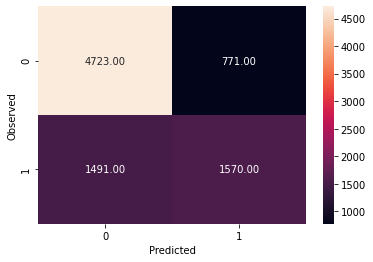

None
              precision    recall  f1-score   support

           1       0.76      0.86      0.81      5494
           2       0.67      0.51      0.58      3061

    accuracy                           0.74      8555
   macro avg       0.72      0.69      0.69      8555
weighted avg       0.73      0.74      0.73      8555



In [100]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression

## function to get confusion matrix in a proper format
def draw_cm( actual, predicted ):
    cm = confusion_matrix( actual, predicted)
    sns.heatmap(cm, annot=True,  fmt='.2f', xticklabels = [0,1] , yticklabels = [0,1] )
    plt.ylabel('Observed')
    plt.xlabel('Predicted')
    plt.show()

print("Training accuracy",round(modelFINAL.score(X_train_scaled,y_train),ndigits=3))
print()
print("Testing accuracy",round(mt.accuracy_score(y_test, y_predict),ndigits=3))
print()
print('Confusion Matrix')
print(draw_cm(y_test,y_predict))

print(classification_report(y_test,y_predict))

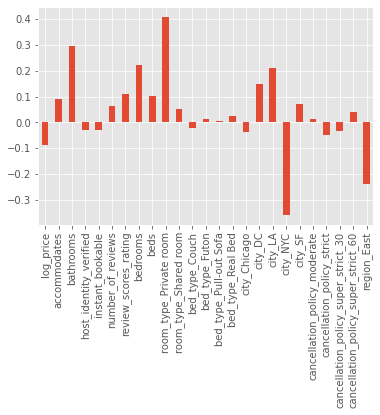

In [161]:
#coeffient plot

from matplotlib import pyplot as pyplot
%matplotlib inline

plt.style.use('ggplot')

weights = pd.Series(modelFINAL.coef_[0],index=x_train.columns)
weights.plot(kind='bar')
plt.show()

### Support Vector Machines

##### Hyperparameter Tuning

For our support vector machine model we applied a grid search function with 10 fold cross validation, to determine which parameters would perform best given our data.

We found that using an alpha 0.01, using a hinge loss and providing a penalty of l2 is optimal for our classification task.

Additionally, the stochastic gradient descent model performed more efficiently with regards to run time since our data was initially quite sparse given the number of columns in our grid due to one hot encoding the neighborhood category.

In [111]:
#https://michael-fuchs-python.netlify.app/2019/11/11/introduction-to-sgd-classifier/

from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
params = {
    "loss" : ["hinge", "log", "squared_hinge", "modified_huber", "perceptron"],
    "alpha" : [0.0001, 0.001, 0.01, 0.1],
    "penalty" : ["l2"],
}
clf = SGDClassifier()
grid = GridSearchCV(clf, param_grid=params, cv=10)
grid.fit(X_train_scaled, y_train)
print(grid.best_params_)

{'alpha': 0.01, 'loss': 'hinge', 'penalty': 'l2'}



The plot below shows the perfomance of different loss metrics on our data and shows hinge perfoming best.

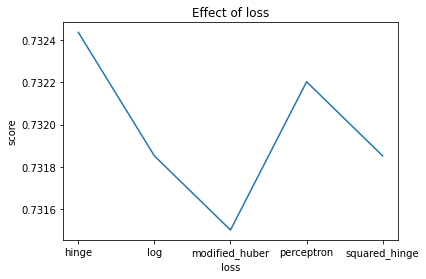

In [125]:
losses = ["hinge", "log", "modified_huber", "perceptron", "squared_hinge"]
scores = []
for loss in losses:
    clf = SGDClassifier(loss='hinge', penalty="l2", alpha=0.01, max_iter=1000)
    clf.fit(X_train_scaled, y_train)
    scores.append(clf.score(X_test_scaled, y_test))
plt.title("Effect of loss")
plt.xlabel("loss")
plt.ylabel("score")
x = np.arange(len(losses))
plt.xticks(x, losses)
plt.plot(x, scores)

##### Final Support Vector Machine Model

After identifying the optimal parameters using the grid search function, we applied them to our final SVM Model.

The model accuracy for our classification task is 73%

In [126]:
svm_model = SGDClassifier(alpha= 0.01, loss= 'hinge', penalty='l2')
svm_model.fit(X_train_scaled, y_train)
grid_predictions = svm_model.predict(X_test_scaled)
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, grid_predictions)))

Accuracy: 0.73


In [127]:
#coefficient list based on class example
weights = svm_model.coef_.T
variable_names = x_train.columns
for coef,name in zip(weights, variable_names):
    print(name, 'has weight of', round(coef[0],ndigits=2))

log_price has weight of 0.01
accommodates has weight of 0.07
bathrooms has weight of 0.16
host_identity_verified has weight of -0.01
instant_bookable has weight of -0.02
number_of_reviews has weight of 0.02
review_scores_rating has weight of 0.04
bedrooms has weight of 0.44
beds has weight of 0.06
room_type_Private room has weight of 0.64
room_type_Shared room has weight of 0.16
bed_type_Couch has weight of -0.03
bed_type_Futon has weight of 0.02
bed_type_Pull-out Sofa has weight of 0.02
bed_type_Real Bed has weight of 0.05
city_Chicago has weight of -0.07
city_DC has weight of 0.19
city_LA has weight of 0.23
city_NYC has weight of -0.37
city_SF has weight of 0.1
cancellation_policy_moderate has weight of 0.01
cancellation_policy_strict has weight of -0.01
cancellation_policy_super_strict_30 has weight of -0.04
cancellation_policy_super_strict_60 has weight of 0.04
region_East has weight of -0.27


### Exceptional work, model performance interpretation SVM

Just like the accuracy in the Logistic Regression, we would assume the model performs quite well based on accuracy score alone. However, when we look at the precision, recall and F1 score for the non-apartment or "other" property type, we see the model does not perform as well as expected. 

Like the Logistic Regression model performance above, the large difference in F1 score between the property type = apartment vs property type = other, signals we should consider rebalancing our lower representative property types to fully leverage their predictive attributes.

This is surprising given the difference in coefficient weights, since the coefficient values differ in weight, we would expect a different performance metrics from the SVM model results. 

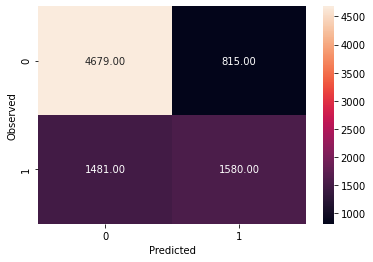

None
              precision    recall  f1-score   support

           1       0.76      0.85      0.80      5494
           2       0.66      0.52      0.58      3061

    accuracy                           0.73      8555
   macro avg       0.71      0.68      0.69      8555
weighted avg       0.72      0.73      0.72      8555



In [109]:
print(draw_cm(y_test, grid_predictions))
print(classification_report(y_test, grid_predictions))

### **Model Comparison**

To determine the best overall model, accuracy, precision, recall and their harmonized value of F1-score were considered as the core metrics. The Logistic Regression model had a slightly better performance based on the F1 score compared to Stochastic Gradient Descent Support Vector Machine model at 81% Vs 80% respectively.

We started modeling the full dataset and the time and efficiency to run each model was quite high. Additionally, the number of unique values in the neighborhood data, which we considered an important attribute at the time made our data structure quite sparse.

To have a better performance on both execution and training of the large amount of data, we moved from SVM to Stochastic Gradient Descent optimized SVM, which improved performance but still had quite a long run time.  We then removed neighborhood (removing the columns with too many values).This reduced the accuracy across all our models by 3%, reducing our accuracy from 76% to 73% but increased the speed and performance for both models.  Another approach would have been to sample the data but we would have to worry about balancing the classes as there are property types that are significantly under-represented in the data set.

Overall the models performed quite similarly in our classification task, we would choose the Logistic Regression model due to the simplicity of the model and our ability to calculate the odds ratio given any set of attributes, predicting the likelihood of a certain classification.